## Описание алгоритма PageRank


PageRank — это числовая величина, характеризующая «важность» веб-страницы. Чем больше ссылок на страницу, тем она «важнее». Кроме того, «вес» страницы А определяется весом ссылки, передаваемой страницей B. Таким образом, PageRank — это метод вычисления веса страницы путём подсчёта важности ссылок на неё.

Формула, для вычисления PageRank, представленная в основополагающей статье Сергея Брина и Ларри Пейджа (отнормированная так, чтобы сумма всeх PageRank была равна единице)
$$ PR(p_i) = \frac{(1 - d)}{N} + d \sum_{p_j \in M(p_i)} \frac{PR(p_j)}{M(p_j)} $$

* $d$ — так называемый демпфирующий коэффициент, отображающий «количество авторитетности», передаваемое страницей-донором (источником ссылки) странице-акцептору (для которой рассчитывается PR). Величина коэффициента засекречена поисковиком, но наблюдения показывают, что с определенной точностью ее можно принять равной 0,85 (то есть 85% передаваемой авторитетности). По другим сведениям, демпфирующий коэффициент показывает вероятность перехода с донорской страницы на акцептор по установленной ссылке. Несмотря на отличие определений, d в этом случае также считают равным 0,85.
* $ p_1 \dots p_n $ — рассматриваемые страницы 
* $M(p_i)$ — страницы, ссылающиеся на $p_i$
* $L(p_i)$ — общее количество внешних ссылок, установленных на $i$-ой странице.
* $N$ — общее количество страниц

Значения PageRank'а составляют правый собственный вектор модифицированной матрицы смежности для графа

$ \begin{align}
    R &= \begin{bmatrix}
           PR(p_1) \\
           PR(p_2) \\
           \vdots \\
           PR(p_N)
         \end{bmatrix}
  \end{align} $

$ \begin{align}
    R &= \begin{bmatrix}
           (1 - d)/N \\
           (1 - d)/N \\
           \vdots \\
           (1 - d)/N
         \end{bmatrix}
  \end{align}  
  + d \begin{bmatrix}
      l(p_1, p_1) & l(p_1, p_2) & \dots & l(p_1, p_N) \\
      l(p_2, p_1) & \ddots & & \vdots \\
      \vdots &  & l(p_i, p_j) & \\
      l(p_N, p_1) & \dots & & l(p_N, p_N) \\
      \end{bmatrix} R
$

где $l(p_i, p_j) = 0$ если $p_j$ не ссылается на $p_i$, и отнормирована таким образом, что $\sum_{i=1}^{N} l(p_i, p_j) = 1 $

In [137]:
import numpy as np
import scipy.sparse as spsp
import scipy.sparse.linalg as splinalg

from scipy import linalg
from scipy.linalg import norm

def generateLowRankMatrix(size, rank):
    matrix = np.zeros((size, size))
    for i in range(rank):
        a = np.random.rand(size, 1)
        b = np.random.rand(1, size)
        matrix = matrix + a.dot(b)
    return matrix

In [108]:
class SolverSettings:
    def __init__(self, eps, maxiter):
        self.eps = eps
        self.maxiter = maxiter

class PowerMethodSolver:
    def __init__(self, settings):
        self.settings = settings
        
    def solve(self, A, y0):
        x = y0 / norm(y0, 2)
        err = 1.0
        points = []
        iterationPoints = []
        errorPoints = []
        currentIteration = 0
        while err > self.settings.eps and currentIteration < self.settings.maxiter:
            y = A.dot(x)
            x = y / norm(y, 2)
            points.append(x.T.dot(A.dot(x)))
            if currentIteration > 0:
                err = abs(points[currentIteration] - points[currentIteration - 1])
                
            errorPoints.append(err)
            iterationPoints.append(currentIteration)
            currentIteration += 1
        
        self.points = points
        self.iterations = currentIteration
        self.iterationPoints = iterationPoints
        self.errorPoints = errorPoints
    
    def getLambdaPoints(self):
        return self.points
    
    def getIterations(self):
        return self.iterations
    
    def getIterationPoints(self):
        return self.iterationPoints
    
    def getErrorPoints(self):
        return self.errorPoints

In [109]:
settings = SolverSettings(1e-10, 1000)
solver = PowerMethodSolver(settings)

In [110]:
size = 100
rank = 10
randomMatrix = generateLowRankMatrix(size, rank)
randomVector = np.random.rand(size)

In [111]:
solver.solve(randomMatrix, randomVector)

Found lambda: 246.276590331
Real lambda: (246.276590331+0j)


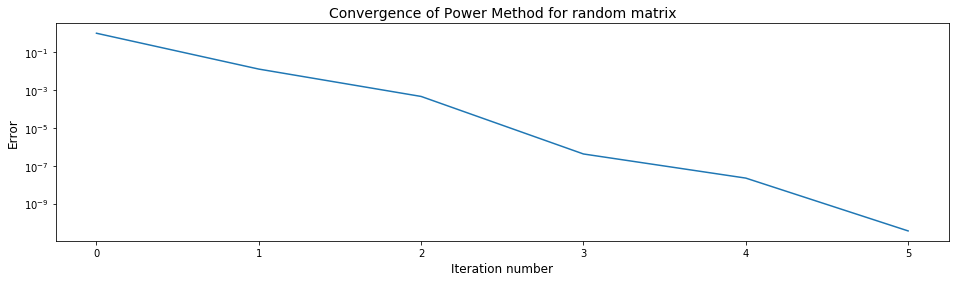

In [132]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 4))
plt.plot(solver.getIterationPoints(), solver.getErrorPoints())
plt.title("Convergence of Power Method for random matrix", fontsize=14)
plt.xlabel("Iteration number", fontsize=12)
plt.ylabel("Error", fontsize=12)
_ = plt.yscale("log")

# plt.figure(figsize=(16, 4))
# plt.plot(solver.getIterationPoints(), solver.getLambdaPoints())
# plt.title("Lambda value", fontsize=14)
# plt.xlabel("Iteration number", fontsize=12)
# _ = plt.ylabel("Lambda", fontsize=12)

print("Found lambda: " + str(solver.getLambdaPoints()[solver.getIterations() - 1]))
print("Real lambda: " + str(np.linalg.eig(randomMatrix)[0][0]))

In [138]:
class AdjacencyMatrix:
    def __init__(self, fileName):
        self.generateFromFile(fileName)
        
    def getMatrix(self):
        return self.matrix
    
    def getNNZ(self):
        return self.nnz
    
    def getLinksCount(self):
        return self.linksCount
    
    def generateFromFile(self, fileName):
        k = 0
        graph = {}
        linkMap = {}
        with open(fileName) as f:
            for line in f:
                if line.startswith("#"):
                    continue
                
                linking = line.split()
                linkFrom = int(linking[0])
                linkTo = int(linking[1])
                # print(linkFrom, linkTo)
                
                if linkMap.get(linkFrom, -1) == -1:
                    linkMap[linkFrom] = k
                    k += 1
                
                if linkMap.get(linkTo, -1) == -1:
                    linkMap[linkTo] = k
                    k += 1
                
                if graph.get(linkFrom, 0) == 0:
                    graph[str(linkFrom)] = [linkTo]
                else:
                    graph[str(linkFrom)].append[linkTo]

        self.linksCount = len(linkMap.values())
        matrix = spsp.lil_matrix((self.linksCount, self.linksCount))

        for strLinkFrom in graph.keys():
            linkFrom = int(strLinkFrom)
            linksTo = graph[strLinkFrom]
            linksOut = len(linksTo)
    
            for link in linksTo:
                # if j->i then Aij = 1
                matrix[linkMap[link], linkMap[linkFrom]] = (1.0 / linksOut)

        self.matrix =  matrix.tocsr()
        self.nnz = matrix.nnz

In [176]:
class SparseGooglePowerMethodSolver:
    def __init__(self, settings):
        self.settings = settings
        
    def solve(self, M, d, y0):
        x = y0 / norm(y0, 2)
        err = 1.0
        points = []
        iterationPoints = []
        errorPoints = []
        currentIteration = 0
        entity = np.ones((matrix.getLinksCount(), 1))
        while err > self.settings.eps and currentIteration < self.settings.maxiter:
            y = d * M.getMatrix().dot(x) + ((1.0 - d) / M.getLinksCount()) * entity.dot((entity.T.dot(x)))
            x = y / norm(y, 2)
            points.append(x.T.dot(M.getMatrix().dot(x))[0])
            if currentIteration > 0:
                err = abs(points[currentIteration] - points[currentIteration - 1])
                
            errorPoints.append(err)
            iterationPoints.append(currentIteration)
            currentIteration += 1
        
        self.points = points
        self.iterations = currentIteration
        self.iterationPoints = iterationPoints
        self.errorPoints = errorPoints
    
    def getLambdaPoints(self):
        return self.points
    
    def getIterations(self):
        return self.iterations
    
    def getIterationPoints(self):
        return self.iterationPoints
    
    def getErrorPoints(self):
        return self.errorPoints

In [177]:
matrix = AdjacencyMatrix('data/graph.txt')
print("NNZ: " + str(matrix.getNNZ()))
print("Links count: " + str(matrix.getLinksCount()))

NNZ: 25059
Links count: 27770


Found lambda: 1.11088367919
Found lambda: 1.11088367942


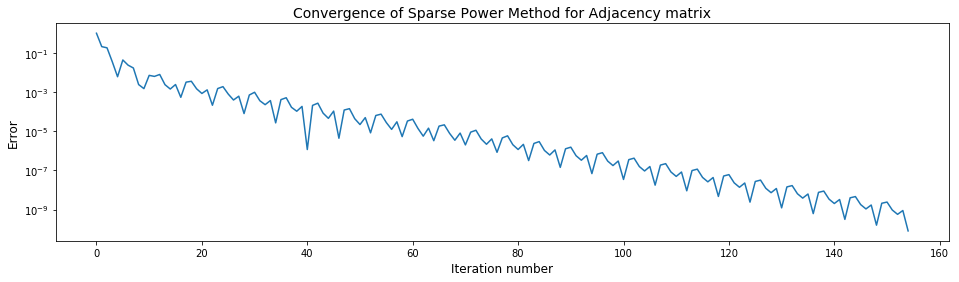

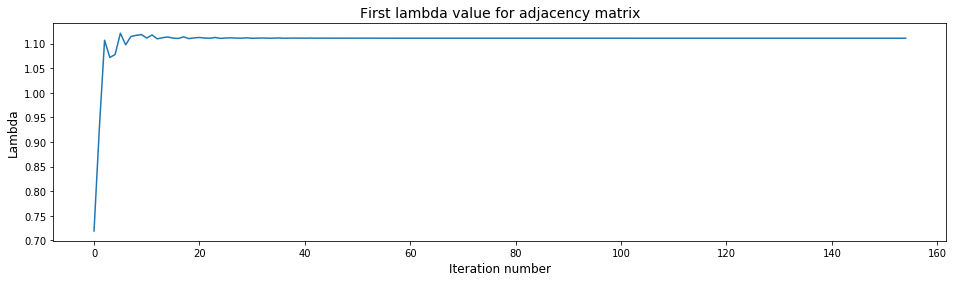

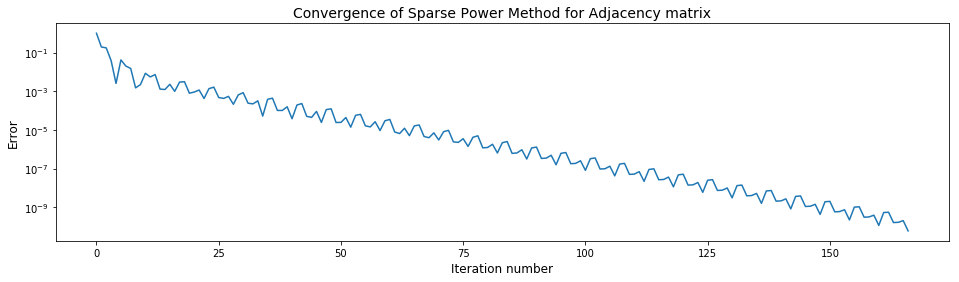

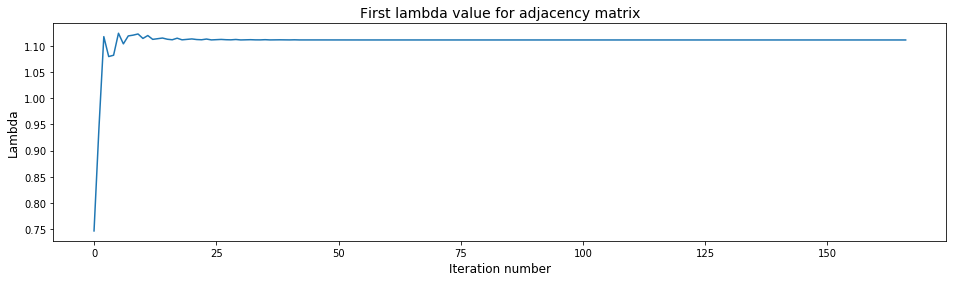

In [179]:
import scipy.sparse.linalg as sparselinalg

settings = SolverSettings(1e-10, 1000)
gSolver = SparseGooglePowerMethodSolver(settings)

v0 = np.abs(np.random.randn(matrix.getLinksCount()).reshape(matrix.getLinksCount(), 1))
gSolver.solve(matrix, 0.85, v0)

plt.figure(figsize=(16, 4))
plt.plot(gSolver.getIterationPoints(), gSolver.getErrorPoints())
plt.title("Convergence of Sparse Power Method for Adjacency matrix", fontsize=14)
plt.xlabel("Iteration number", fontsize=12)
plt.ylabel("Error", fontsize=12)
_ = plt.yscale("log")

plt.figure(figsize=(16, 4))
plt.plot(gSolver.getIterationPoints(), gSolver.getLambdaPoints())
plt.title("First lambda value for adjacency matrix", fontsize=14)
plt.xlabel("Iteration number", fontsize=12)
_ = plt.ylabel("Lambda", fontsize=12)

print("Found lambda: " + str(gSolver.getLambdaPoints()[gSolver.getIterations() - 1][0]))

v0 = np.ones((matrix.getLinksCount(), 1))
gSolver.solve(matrix, 0.85, v0)

plt.figure(figsize=(16, 4))
plt.plot(gSolver.getIterationPoints(), gSolver.getErrorPoints())
plt.title("Convergence of Sparse Power Method for Adjacency matrix", fontsize=14)
plt.xlabel("Iteration number", fontsize=12)
plt.ylabel("Error", fontsize=12)
_ = plt.yscale("log")

plt.figure(figsize=(16, 4))
plt.plot(gSolver.getIterationPoints(), gSolver.getLambdaPoints())
plt.title("First lambda value for adjacency matrix", fontsize=14)
plt.xlabel("Iteration number", fontsize=12)
_ = plt.ylabel("Lambda", fontsize=12)

print("Found lambda: " + str(gSolver.getLambdaPoints()[gSolver.getIterations() - 1][0]))